In [5]:
# prove the right order of phase corretion: atmos, dem_error, ramp

import os
import shutil
import numpy as np
from matplotlib import ticker, pyplot as plt, gridspec
from pysar.objects import timeseries, sensor, geometry
from pysar.utils import plot as pp, network as pnet, ptime, readfile, writefile
from pysar.simulation import simulation as sim
from pysar.simulation.plot import *


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/phaseCorrection_order'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)


# settings
lin_velocity = False
display = True


# reference timeseries file
ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
sensorName = sensor.project_name2sensor(ref_dir)[0]

ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)
tbase = np.array(ts_obj.tbase)

num_date, length, width = ts_obj.numDate, ts_obj.length, ts_obj.width
ts_dem_err_file = 'timeseriesDemErr.h5'

for fname in ['waterMask.h5',
              'demErr.h5',
              'ramp.h5',
              'INPUTS/geometryRadar.h5',
              'INPUTS/ECMWF.h5',
              'INPUTS/MERRA.h5']:
    if not os.path.isfile(os.path.basename(fname)):
        shutil.copy2(os.path.join(ref_dir, fname), './')
        print('copy {} to work directory.'.format(fname))

print('Done.')

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/phaseCorrection_order
open timeseries file: timeseries.h5
Done.


save range change time series to file.
true velocity model: 0.3105 cm/yr


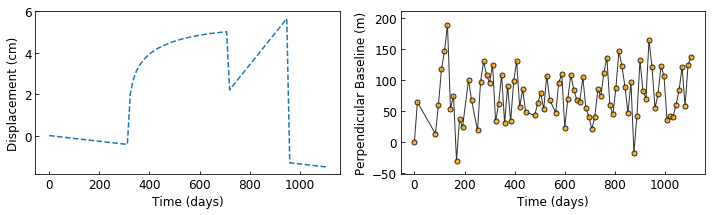

Done.


In [2]:
## 1. Simulate timeseries

TS_TXT_FILE = 'timeseries'
if lin_velocity:
    # Opt 1 - Linear velocity
    ts_sim = sim.velocity2timeseries(date_list, vel=0.01, display=False)
else:
    # Opt 2 - Time variable
    ts_sim = np.zeros(tbase.shape, np.float32)
    idx1 = 20
    ts_sim[idx1:] = 0.01 * np.log(tbase[idx1:] - tbase[idx1-1])
    idx2 = 50
    ts_sim[idx2:] = 0.03 + 0.06 * (tbase[idx2:] - tbase[idx2-1]) / 365.25
    idx3 = 70
    ts_sim[idx3:] = 0.
    ts_sim += tbase * -0.005 / 365.25

np.save(TS_TXT_FILE, np.hstack((np.array(date_list).reshape(-1,1), ts_sim.reshape(-1,1))))
print('save range change time series to file.')

sim_vel = sim.timeseries2velocity(date_list, ts_sim)
print('true velocity model: {:.4f} cm/yr'.format(sim_vel[0]*100.))

if display:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12, 3])
    ax1.plot(tbase, ts_sim * 100., '--')
    ax1.set_xlabel('Time (days)', fontsize=font_size)
    ax1.set_ylabel('Displacement (cm)', fontsize=font_size)
    ax1.tick_params(direction='in', labelsize=font_size)
    
    ax2.plot(tbase_list, pbase_list, '-ko', alpha=0.8, lw=1, ms=marker_size, mfc='orange')
    ax2 = pp.auto_adjust_yaxis(ax2, pbase_list, font_size)
    ax2.set_xlabel('Time (days)',fontsize=font_size)
    ax2.set_ylabel('Perpendicular Baseline (m)',fontsize=font_size)
    ax2.tick_params(direction='in', labelsize=font_size)
    plt.show()
print('Done.')

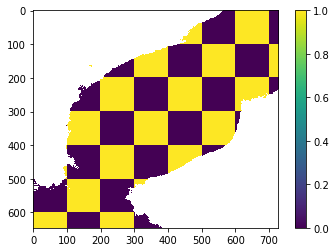

create timeseries HDF5 file: timeseriesSim.h5 with w mode
create dataset /timeseries of float32    in size of (83, 646, 729)
create dataset /dates      of |S8        in size of (83,)
create dataset /bperp      of float32    in size of (83,)
finished writing to timeseriesSim.h5
Done.


In [3]:
# Create check board timeseries
grid_step = 100
water_mask = readfile.read('waterMask.h5')[0]
mask = sim.check_board(water_mask, grid_step)
sim_ts_data = np.zeros((num_date, length, width), np.float32)
for i in range(num_date):
    sim_ts_data[i, :, :] = ts_sim[i] * mask

ts_sim_file = 'timeseriesSim.h5'
writefile.write(sim_ts_data, out_file=ts_sim_file, ref_file=ref_ts_file)
print('Done.')
    

In [15]:
# generate timeseriesDemErr.h5 from demErr.h5

geom_obj = geometry('geometryRadar.h5')
inc_angle = geom_obj.read(datasetName='incidenceAngle')
rg_dist = geom_obj.read(datasetName='slantRangeDistance')
pbase3d = geom_obj.read(datasetName='bperp')
dem_err = readfile.read('demErr.h5')[0]

ts_dem_err = np.zeros((num_date, length, width), np.float32)
for i in range(num_date):
    pbase = pbase3d[i, :, :] - pbase3d[ts_obj.refIndex, :, :]
    ts_dem_err[i, :, :] = dem_err * pbase / (rg_dist * np.sin(inc_angle * np.pi / 180.))

writefile.write(ts_dem_err, out_file=ts_dem_err_file, ref_file=ref_ts_file)
print('Done.')


reading incidenceAngle data from file: geometryRadar.h5 ...
reading slantRangeDistance data from file: geometryRadar.h5 ...
reading bperp data from file: geometryRadar.h5 ...
create timeseries HDF5 file: timeseriesDemErr.h5 with w mode
create dataset /timeseries of float32    in size of (83, 646, 729)
create dataset /dates      of |S8        in size of (83,)
create dataset /bperp      of float32    in size of (83,)
finished writing to timeseriesDemErr.h5
Done.


In [6]:
# create timeseries with displacement, tropo delay, dem error and ramps

ts_data = np.zeros((num_date, length, width), np.float32)
for fname in [ts_sim_file, ts_dem_err_file, 'MERRA.h5', 'ramp.h5']:
    data = readfile.read(fname)[0]
    ts_data += data
writefile.write(ts_data, out_file='timeseries.h5', ref_file=ref_ts_file)
print('Done.')

reading timeseries data from file: timeseriesSim.h5 ...
reading timeseries data from file: timeseriesDemErr.h5 ...
reading timeseries data from file: MERRA.h5 ...
reading timeseries data from file: ramp.h5 ...
create timeseries HDF5 file: timeseries.h5 with w mode
create dataset /timeseries of float32    in size of (83, 646, 729)
create dataset /dates      of |S8        in size of (83,)
create dataset /bperp      of float32    in size of (83,)
finished writing to timeseries.h5
Done.


In [ ]:
## PySAR order: tropo + demErr + ramp

ts_file1 = 'timeseries_ECMWF_demErr_ramp'
